# The Truth Particles Collection

The Truth particle collections are rich with information. Unfortunately, they are also a little tricky because what is actually available in an event depends on the sliming algorithms that are applied to the data. The code to access the data is always the same - but the fact that the data is there or not will depend on the file's processing history. Protecting against that makes our code a bit more complex, as you'll see below.

In [1]:
import matplotlib.pyplot as plt
from config import ds_jz2_exot15 as ds
import numpy as np
import pandas as pd
from particle import Particle
from hist import Hist

pd.options.display.max_rows = None

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


You'll note above we are using `ds_jz2_exot15`. This is a Run 2 derivation, and not a `DAOD_PHYS` file. The reason is this has large `TruthParticles` and `TruthVertices` collections. `DAOD_PHYS` has `TruthParticles` collections, but only for select particles (`TruthBottom`, `TruthTop`, `TruthBSM`, for example). To demonstrate moving between particles and vertices we wanted something more complex to demonstrate.

We'll start with particles.

In [2]:
all_particles = (ds
                 .SelectMany(lambda e: e.TruthParticles("TruthParticles"))
                 .Where(lambda tp: (tp.pt() / 1000) > 1)
                 .Select(lambda tp: {
                         'pt': tp.pt() / 1000.0,
                         'pdgId': abs(tp.pdgId()),
                 })
                 .AsAwkwardArray()
                 .value())

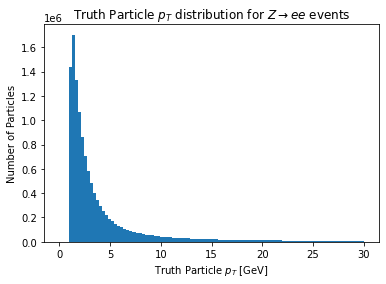

In [3]:
plt.hist(all_particles.pt, bins=100, range=(0, 30))
plt.xlabel('Truth Particle $p_T$ [GeV]')
plt.ylabel('Number of Particles')
_ = plt.title(r'Truth Particle $p_T$ distribution for $Z\rightarrow ee$ events')

Lets take a very quick look at the pdgid's that we have in the data we are looking at. Note that we already applied, above, `abs` to the `pdgID` to make this list more compact. We'll use the amazing [particle](https://pypi.org/project/particle/) pypi package to get particle names. One thing is there are a few particles that aren't in the database, so we need to protect that lookup during the lookup. Note that it is possible to create ones own named particles and add them - so this could be done in one's own analysis if desired.

In [4]:
def get_pdg_name(pdgid: int) -> str:
    'Protected particle name from pdgid'
    if pdgid == 35:
        return 'LLP'
    try:
        return Particle.from_pdgid(pdgid).name
    except:
        # Protect against unknown particle id's
        return f'Unknown: {pdgid}'

# Use a pandas DataFrame to make displaying a table of particles easy.
unique, counts = np.unique(all_particles.pdgId, return_counts=True)
df = pd.DataFrame({'PDGId' : unique, 'Count': counts, 'Name': [get_pdg_name(int(i)) for i in unique] })
df['PDGId'] = df['PDGId'].astype(int)
df[df.Count>100].sort_values('Name')

,PDGId,Count,Name
53,1103,122,(dd)(1)
55,2101,5482,(ud)(0)
56,2103,1962,(ud)(1)
59,2203,3528,(uu)(1)
49,533,322,B(s)*0
48,531,656,B(s)0
47,523,1354,B*+
45,513,1368,B*0
46,521,2034,B+
44,511,2280,B0


## Truth Vertices

Lets explore the decay chain a bit. Lets look at what $b$-quarks hadrons decay into in this sample, and how far a way from their production the hadrons decay. The ATLAS data model has several ways to follow the decay chain. Because we want to understand decay distances, we will need to use the `TruthVertex` object.

The ATLAS truth data model is, in the world of infinite disk space, quite straight forward. Every `TruthParticle` has a production and a decay `TruthVertex` associated with it. As long as the particle isn't stable (like an electron). However, in order to keep disk space under control in many cases the children or parent vertices may be missing. This leads us to a number of caveats that have to be encoded in our query:

* In ATLAS, particles don't have to have production or decay vertices. If this is the case, then the link to the production or decay vertex will be a null pointer (at least, in C++). And if you generate code that references it, you'll get a hard segfault in ServiceX. So, always check to see if the vertex you are interested in exists!
* $b$-quarks can radiate, and thus decay into another $b$ quark and a $\gamma$ or similar. We are not interested in those decays.
* The $b$-quark hadronizes almost immediately, of course. So we are really interested in what the thing the $b$-quark hadronizes into is.
* The hadronization isn't straight forward, due to color strings, etc.

In [5]:
real_children = (
          ds
          .SelectMany(lambda e: e.TruthParticles("TruthParticles"))
          .Where(lambda tp: (abs(tp.pdgId()) == 5))
          .Where(lambda tp: tp.hasDecayVtx())
          .Where(lambda tp: tp.decayVtx().outgoingParticleLinks().Where(lambda dtp: dtp.isValid()).Where(lambda dtp: abs(dtp.pdgId()) == 5).Count() == 0)
          .SelectMany(lambda tp: tp.decayVtx().outgoingParticleLinks())
          .Where(lambda tp: tp.isValid())
          .Where(lambda tp: tp.hasBottom())
          .Where(lambda tp: tp.hasProdVtx() and tp.hasDecayVtx())
)

Note the protections in this code:

* Use of `hasDecayVtx` and `hasProdVtx` - which tell us if the thing has any vertices at all.
* Use of `isValid`, which is used against an `ElementLink<X>` object. If a particle has been removed during derivation, then `ElementLink` will point to nothing. `isValid` protects us from trying to follow that dead end link.

In [6]:
children = (real_children
    .Select(lambda tp: {
        'pdgId': abs(tp.pdgId()),
        'dx': abs(tp.prodVtx().x() - tp.decayVtx().x()),
        'dy': abs(tp.prodVtx().y() - tp.decayVtx().y()),
        'dz': abs(tp.prodVtx().z() - tp.decayVtx().z()),
    })
    .AsAwkwardArray()
    .value()
)

Dump out the names of all the hadrons. Partly, this is to make sure we got it right!

In [7]:
unique, counts = np.unique(children.pdgId, return_counts=True)
df = pd.DataFrame({'PDGId' : unique, 'Count': counts, 'Name': [get_pdg_name(int(i)) for i in unique] })
df['PDGId'] = df['PDGId'].astype(int)
df.sort_values('Count', ascending=False)

,PDGId,Count,Name
1,513,1421,B*0
3,523,1401,B*+
2,521,698,B+
0,511,599,B0
5,533,336,B(s)*0
4,531,123,B(s)0
9,5122,110,Lambda(b)0
12,5214,27,Unknown: 5214
10,5132,25,Xi(b)-
8,5114,21,Sigma(b)*-


And, now we can calculate the decay distance:

In [8]:
decay_length_all = np.sqrt(children.dx**2 + children.dy**2 + children.dz**2)
pdg_name_all = np.array([get_pdg_name(int(i)) for i in children.pdgId])
good_decay = decay_length_all > 0.0

In [9]:
h = (
  Hist.new
  .Reg(50, 0 ,20, name="dl", label="Decay Length [mm]")
  .StrCategory([], name="pdg", label="Particle", growth=True)
  .Int64()
)
_ = h.fill(dl=decay_length_all[good_decay], pdg=pdg_name_all[good_decay])

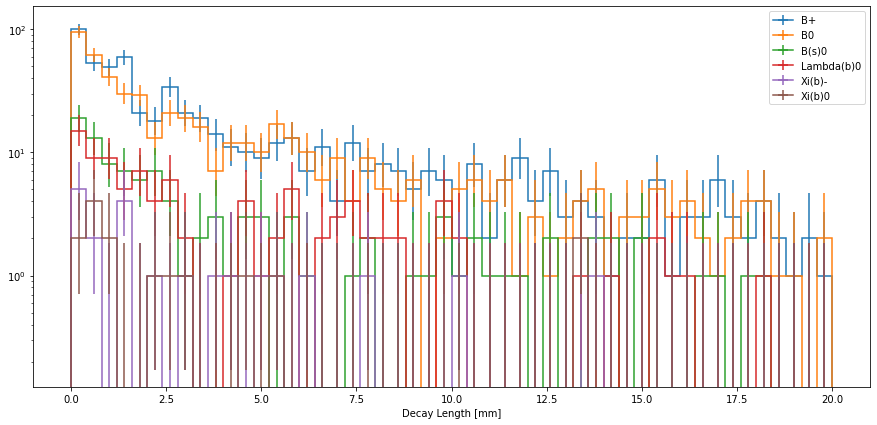

In [10]:
plt.figure(figsize=(15, 7))
h.plot()
plt.yscale('log')
_ = plt.legend()

I love this plot because it shows the different decay probabilities. There are differences in lifetime, but they are harder to see because we aren't showing $c\tau$ here (and correcting for boost, mass, etc.).

## The Datamodel

The data model when this documentation was last built was:

In [11]:
from func_adl_servicex_xaodr21.xAOD.truthevent_v1 import TruthEvent_v1
help(TruthEvent_v1)

Help on class TruthEvent_v1 in module func_adl_servicex_xaodr21.xAOD.truthevent_v1:

class TruthEvent_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  beamParticle1Link(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_truthparticle_v1__.ElementLink_DataVector_xAOD_TruthParticle_v1__'
 |      A method
 |  
 |  beamParticle2Link(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_truthparticle_v1__.ElementLink_DataVector_xAOD_TruthParticle_v1__'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  crossSection(self) -> 'float'
 |      A method
 |  
 |  crossSectionError(self) -> 'float'
 |      A method
 |  
 |  hasNonConstStore(self) -> 'bool'
 |      A method
 |  
 |  hasStore(self) -> 'bool'
 |      A method
 |  
 |  index(self) -> 'int'
 |      A method
 |  
 |  nTruthParticles(self) -> 'int'
 |      A method
 |  
 |  nTruthVertices(self) -> 'int'
 |      A method
 |  
 |  pdfInfo(self) -> 'func_adl_ser

In [12]:
from func_adl_servicex_xaodr21.xAOD.truthparticle_v1 import TruthParticle_v1
help(TruthParticle_v1)

Help on class TruthParticle_v1 in module func_adl_servicex_xaodr21.xAOD.truthparticle_v1:

class TruthParticle_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  absPdgId(self) -> 'int'
 |      A method
 |  
 |  abseta(self) -> 'float'
 |      A method
 |  
 |  absrapidity(self) -> 'float'
 |      A method
 |  
 |  barcode(self) -> 'int'
 |      A method
 |  
 |  charge(self) -> 'float'
 |      A method
 |  
 |  child(self, i: 'int') -> 'func_adl_servicex_xaodr21.xAOD.truthparticle_v1.TruthParticle_v1'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  decayVtx(self) -> 'func_adl_servicex_xaodr21.xAOD.truthvertex_v1.TruthVertex_v1'
 |      A method
 |  
 |  decayVtxLink(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_truthvertex_v1__.ElementLink_DataVector_xAOD_TruthVertex_v1__'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  hasBottom(self) -> 'b

In [13]:
from func_adl_servicex_xaodr21.xAOD.truthvertex_v1 import TruthVertex_v1
help(TruthVertex_v1)

Help on class TruthVertex_v1 in module func_adl_servicex_xaodr21.xAOD.truthvertex_v1:

class TruthVertex_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  barcode(self) -> 'int'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  hasNonConstStore(self) -> 'bool'
 |      A method
 |  
 |  hasStore(self) -> 'bool'
 |      A method
 |  
 |  id(self) -> 'int'
 |      A method
 |  
 |  incomingParticle(self, index: 'int') -> 'func_adl_servicex_xaodr21.xAOD.truthparticle_v1.TruthParticle_v1'
 |      A method
 |  
 |  incomingParticleLinks(self) -> 'func_adl_servicex_xaodr21.vector_elementlink_datavector_xaod_truthparticle_v1___.vector_ElementLink_DataVector_xAOD_TruthParticle_v1___'
 |      A method
 |  
 |  index(self) -> 'int'
 |      A method
 |  
 |  nIncomingParticles(self) -> 'int'
 |      A method
 |  
 |  nOutgoingParticles(self) -> 'int'
 |      A method
 |  
 |  outgoingParticle(se

## Further Information

* The [`xAOD::TruthEvent_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthEvent_v1.h) with all the inline documentation.
* The [`xAOD::TruthParticle_v1` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthParticle_v1.h) with all the inline documentation.
* The [`xAOD::TruthVertex_v1` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthVertex_v1.h) with all the inline documentation.
* The [`xAOD::TruthPileupEvent_v1` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthPileupEvent_v1.h) with all the inline documentation.